## 組織運営活動のタスク内容の構文分析

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from janome.tokenizer import Tokenizer
from janome.analyzer import Analyzer
from janome.charfilter import *
from janome.tokenfilter import *
from wordcloud import WordCloud
import collections
sns.set(font="IPAexGothic")

# 現在の最大表示列数の出力
pd.get_option("display.max_columns")
# 最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

# 現在の最大表示列数の出力
pd.get_option("display.max_rows")
# 最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_rows', 100)

sns.set(font=['IPAexGothic'])
%matplotlib inline

In [2]:
input_path = '../input/'

<br>
<p>前処理後のデータインプット</p>

In [3]:
workrecords = pd.read_pickle(input_path+'../input/workrecords_processed.zip')

<br>
<p>対象を絞る</p>
<p>組織運営活動＆2020年以降のデータで実施。</p>
<p>組織運営会議に関しては今回の方向性で問題ないか確認後に実施。</p>

In [4]:
workrecords_organization_management = workrecords[(workrecords['SGTASKNM']=='組織運営活動')&(workrecords['year_month'] > 202000)]
workrecords_organization_management = workrecords_organization_management.reset_index(drop=True)
workrecords_organization_management = workrecords_organization_management.reset_index()

<br>
<p>まずはテキスト加工する。</p>
<p>形態素解析を実施。</p>
<p>単名詞だとタスクの意味が分からないので複合名詞で抽出。</p>
<p>お試しで10行実施してみる。</p>

In [5]:
# analyzerモジュールで形態素分析
char_filters = [UnicodeNormalizeCharFilter()]

tokenizer = Tokenizer()

token_filters = [CompoundNounFilter(),
                 POSStopFilter(['記号','助詞']),
                 LowerCaseFilter()]

a = Analyzer(char_filters=char_filters, tokenizer=tokenizer ,token_filters=token_filters)

text_list = workrecords_organization_management['SGSYOUS'].values.tolist() # 作業詳細をリスト型で取得

for text in text_list[:10]: # お試しで10行解析してみる
    for token in a.analyze(text):
        print(token)

月	名詞,一般,*,*,*,*,月,ツキ,ツキ
初	接頭詞,名詞接続,*,*,*,*,初,ハツ,ハツ
作業(作業実績アップロード	名詞,複合,*,*,*,*,作業(作業実績アップロード,サギョウ*サギョウジッセキアップロード,サギョー*サギョージッセキアップロード
認印)	名詞,複合,*,*,*,*,認印),ミトメイン*,ミトメイン*
作業実績集計修正	名詞,複合,*,*,*,*,作業実績集計修正,サギョウジッセキシュウケイシュウセイ,サギョージッセキシューケイシューセイ
作業実績集計	名詞,複合,*,*,*,*,作業実績集計,サギョウジッセキシュウケイ,サギョージッセキシューケイ
開発依頼テーマ登録	名詞,複合,*,*,*,*,開発依頼テーマ登録,カイハツイライテーマトウロク,カイハツイライテーマトーロク
作業実績集計手順書修正	名詞,複合,*,*,*,*,作業実績集計手順書修正,サギョウジッセキシュウケイテジュンショシュウセイ,サギョージッセキシューケイテジュンショシューセイ
作業実績確認	名詞,複合,*,*,*,*,作業実績確認,サギョウジッセキカクニン,サギョージッセキカクニン
o365	名詞,複合,*,*,*,*,o365,**,**
spo作成	名詞,複合,*,*,*,*,spo作成,*サクセイ,*サクセイ
電話応対	名詞,複合,*,*,*,*,電話応対,デンワオウタイ,デンワオータイ
対応	名詞,サ変接続,*,*,*,*,対応,タイオウ,タイオー
作業実績集計	名詞,複合,*,*,*,*,作業実績集計,サギョウジッセキシュウケイ,サギョージッセキシューケイ
作業実績提出用メール作成	名詞,複合,*,*,*,*,作業実績提出用メール作成,サギョウジッセキテイシュツヨウメールサクセイ,サギョージッセキテイシュツヨーメールサクセイ
spoページ作成	名詞,複合,*,*,*,*,spoページ作成,*ページサクセイ,*ページサクセイ
確認事項	名詞,複合,*,*,*,*,確認事項,カクニンジコウ,カクニンジコー


<br>
<p>いい感じで出来ているので本番。</p>
<p>本番は不要な記号、単語は除き。surfaceのみ抽出。</p>

In [6]:
def analyze(text_list:list, replace_dict:dict, exclude_task_list:list):
    # analyzerモジュールで形態素分析
    char_filters = [UnicodeNormalizeCharFilter()]

    tokenizer = Tokenizer()

    token_filters = [CompoundNounFilter(),
                     POSStopFilter(['記号','助詞']),
                     LowerCaseFilter(),
                     ExtractAttributeFilter('surface')]

    a = Analyzer(char_filters=char_filters, tokenizer=tokenizer ,token_filters=token_filters)
    
    token_list = []
    
    for text in text_list:
        for token in a.analyze(text):
            token = token.translate(str.maketrans(replace_dict)) # 邪魔な文字を除く
            if token not in exclude_task_list and not token.isdecimal(): # 意味ないワードを除く
                token_list.append(token)
    
    return token_list

In [7]:
replace_dict = {'[':'', ']':'', '/':'', '+':'', '(':'', ')':'', '等':'', ',':'', '.':'', '<':'', '>':'', '-':'', '?':''}
exclude_task_list = ['', 'その他', '他']
text_list = workrecords_organization_management['SGSYOUS'].values.tolist() # 作業詳細をリスト型で取得

token_list = analyze(text_list, replace_dict, exclude_task_list)

In [8]:
len(token_list)

1082

<br>
<p>16630ワード抽出された。</p>

In [9]:
len(set(token_list))

400

<br>
<p>単語の種類は3783種類。</p>

In [10]:
collections.Counter(token_list).most_common(20)

[('メールチェック', 47),
 ('作業', 42),
 ('タスク管理', 42),
 ('sec', 24),
 ('作業実績', 22),
 ('その他作業メール', 21),
 ('電話', 21),
 ('朝礼', 21),
 ('雑務', 21),
 ('その他庶務メール確認', 21),
 ('直接対応', 21),
 ('作業場片付け', 21),
 ('締め作業作業工数', 21),
 ('勤務表登録バックアップ', 21),
 ('スケジュール管理', 21),
 ('メールタスク管理雑務', 15),
 ('運用', 13),
 ('工程審議会', 11),
 ('メール', 11),
 ('チャットチェック', 10)]

<br>
<p>メールやタスク管理、作業実績など定期的に発生するタスクが頻出ワード。</p>
<p>nwはネットワークの略の模様(一部NWAISもありそう)。</p>
<p>wordcloudを作ってみる。</p>

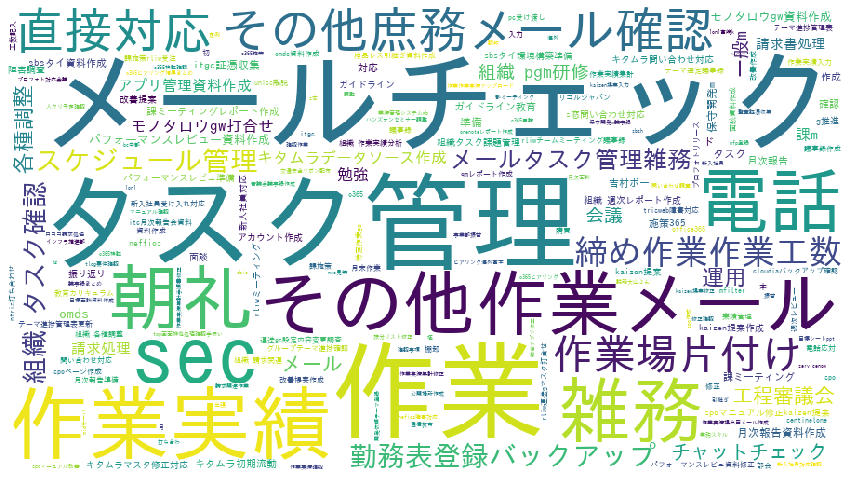

In [11]:
text = " ".join(token_list)

fpath = "../input/ipag.ttf"
wordcloud = WordCloud(background_color="white", font_path=fpath, width=900, height=500, collocations=False).generate(text)

plt.figure(figsize=(15,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

wordcloud.to_file("./wordcloud.png")

<br>
<p>月単位で傾向があるか見てみる。</p>

In [12]:
token_dict = {}

for month in workrecords_organization_management['month'].unique():
    text_list = workrecords_organization_management[workrecords_organization_management['month']==month]['SGSYOUS'].values.tolist() # 作業詳細をリスト型で取得

    token_list = analyze(text_list, replace_dict, exclude_task_list)
                
    token_dict[month] = token_list

In [13]:
for month in workrecords_organization_management['month'].unique():
    print(f'========================{month}月===============')
    print(collections.Counter(token_dict[month]).most_common(20))

========================4月===============
[('メールチェック', 47), ('作業', 42), ('タスク管理', 42), ('sec', 24), ('作業実績', 22), ('その他作業メール', 21), ('電話', 21), ('朝礼', 21), ('雑務', 21), ('その他庶務メール確認', 21), ('直接対応', 21), ('作業場片付け', 21), ('締め作業作業工数', 21), ('勤務表登録バックアップ', 21), ('スケジュール管理', 21), ('メールタスク管理雑務', 15), ('運用', 13), ('工程審議会', 11), ('メール', 11), ('チャットチェック', 10)]


<br>
<p>NWは時期によって前後している。逆にタスク管理やメールチェックは常に上位。</p>
<p>NWと入っているレコードを確認。</p>

In [14]:
workrecords_organization_management[workrecords_organization_management['SGSYOUS'].str.contains('3回')]

,index,TANTOID,TANTONM,KAIRAINO,KAIRAINM,JIGYOCD,JIGYONM,NINUSNM,SYSTEMCD,SYSTEMNM,SGTASKCD,SGTASKNM,SEIKSKCD,SEIKSKNM,SGJSKDA,SGKOUSU,SGSYOUS,TICKETNO,KAISYACD,year_month,year,month,曜日,day,comments_length


<br>
<p>同じネットワークでもタスクで見ると結構内容が異なる。</p>
<p>続いてタスク単位で分類。</p>
<p>色々試行錯誤したが機械的に割り振るのは難しそうなので形態素解析をした後は手動でタスクをラベリング。</p>

In [15]:
def word_normalization(text_list , replacing_list, replace_word):
    return [replace_word if i in replacing_list else i for i in text_list]

In [16]:
def reverse_word_normalization(text_list , replacing_word, replace_word):
    return [replace_word if replacing_word in i else i for i in text_list]

In [17]:
mail_task_list = ['メール', 'メールチェック', 'メールチェック問合わせ', 'メール確認', 'その他作業メール', '雑務メール', 'メール確認作業', ]
schedule_task_list = ['スケジュール管理', 'スケジュールタスク管理', 'スケジュール管理メール', 'スケジュール', 'スケジュール調整', 'メールスケジュールタスク管理']
task_list = ['タスク整理', 'タスク調整', 'タスク管理調整', 'タスク管理', 'タスク洗い出し', 'タスク確認']
telephone_task_list = ['電話', '電話対応', '雑務電話', '電話応対']
billing_task_list = ['請求書', '作業実績請求書処理', '請求書処理', '請求処理', '対応請求書', '請求関連', '請求業務', '請求雑務']
section_mtg_task_list = ['レポート作成','課mレポート作成&ミーティング', '運用課mb作成', '課m報告レポート作成', '課mtgレポート作成', '交通費・課m準備', '課m・課施策', '課mtg準備',  '説明課mレポート作成',
                         '運用課mtg', '課mレポート', '課m', '課mレポート作成', '課mtg資料作成', '課m準備', '課mtg対応', '課mtg','課mtg資料整理', '課ミーティング', '課運営関連']

In [18]:
workrecords_organization_management.index

RangeIndex(start=0, stop=679, step=1)

<br>
<p>

In [19]:
replace_dict = {'[':'', ']':'', '/':'', '+':'', '(':'', ')':'', '等':'', ',':'', '.':'', '<':'', '>':'', '-':'', '?':''}
exclude_task_list = ['', 'その他', '他', '作業', 'nw', 'o365', '五反田', 'ls本部', '運用', '準備',
                      '調整', '組織活動対応継続費用', '組織活動', '第', '確認', '対応', 'ノートpcチェック', 
                      '会議', '資料作成', 'sec', 'pc' , '定例会', '...', '作成', '新', '確認作業']

filter_list = ['スケジュール管理', '電話対応', '課MTG・レポート作成', '議事録作成', 'S窓関係', 
               'パフォーマンスレビュー関係', '面談関係', '掃除', '研修・教育関係', '雑務', '朝礼',
               'SAP入力・評価', '月次報告関係', '審議会', 'サービスデスク・問い合わせ対応', '請求処理', 
               '作業実績', 'ユニリタユーザー会', 'KAIZEN提案', 'PC移行作業', '課題管理', 'タスク管理', 
               'メール対応', 'm-filter', 'テーマ進捗管理表', '購買依頼', '現場・マシン応援', '持出管理',
               'センターミーティング', 'スキルチェックシート関係', 'rgテーマ推進', 'gt関連作業', 'プロジェクト管理', 
               'インシデント', '方針発表会', 'モーションボード関連', '目標関係', 'データ分析', '棚卸業務', 'ネットワーク',
               '障害対応', 'オフィス365関連', 'アップデート', 'その他会議', '運用管理', '健康診断', 'データ移行作業', 
               'リリース作業', 'セットアップ作業', 'その他資料作成', '人財クリエーター', '重点施策関係', 'notes関連',
               '環境構築関係', 'インストール', 'レビュー', '引き継ぎ', 'テーマ選定', '移動', '資料確認', '1903関連',
               '検証作業', 'アカウント関連']

char_filters = [UnicodeNormalizeCharFilter()]

token_filters = [CompoundNounFilter(),
                 POSStopFilter(['記号','助詞']),
                 LowerCaseFilter(),
                 ExtractAttributeFilter('surface')]

a = Analyzer(char_filters=char_filters, token_filters=token_filters)

text_list = workrecords_organization_management['SGSYOUS'].values.tolist()
sgkousu_list = workrecords_organization_management['SGKOUSU'].values
tantonm_list = workrecords_organization_management['TANTONM'].values
year_month_list = workrecords_organization_management['year_month'].values
index = workrecords_organization_management.index

worke_list = []

for sgkousu, text, tantonm, year_month, index in zip(sgkousu_list, text_list, tantonm_list, year_month_list, index):
    morpheme_list = list(set([token for token in a.analyze(text)]))
    morpheme_list_processed = [s.translate(str.maketrans(replace_dict)) for s in morpheme_list]
    morpheme_list_processed = [re.sub('さん$', '', s) for s in morpheme_list_processed]
    
#     morpheme_list_processed = word_normalization(morpheme_list_processed , mail_task_list, 'メール対応')
    morpheme_list_processed = word_normalization(morpheme_list_processed , schedule_task_list, 'スケジュール管理')
#     morpheme_list_processed = word_normalization(morpheme_list_processed , task_list, 'タスク管理')
    morpheme_list_processed = word_normalization(morpheme_list_processed , telephone_task_list, '電話対応')
#     morpheme_list_processed = word_normalization(morpheme_list_processed , billing_task_list, '請求書処理')
    morpheme_list_processed = word_normalization(morpheme_list_processed , section_mtg_task_list, '課MTG・レポート作成')
    
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '議事録', '議事録作成')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 's窓', 'S窓関係')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'パフォーマンスレビュー', 'パフォーマンスレビュー関係')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'パフォーマンスレビュ', 'パフォーマンスレビュー関係')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'パーフォーマンスレビュー', 'パフォーマンスレビュー関係')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'パフォーマンレビュー', 'パフォーマンスレビュー関係')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '面談', '面談関係')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '1on1', '面談関係')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '掃除', '掃除')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'クリーン', '掃除')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '研修', '研修・教育関係')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '勉強', '研修・教育関係')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '講習', '研修・教育関係')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'モック', '研修・教育関係')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'カリキュラム', '研修・教育関係')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'ハンズオン', '研修・教育関係')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '教育', '研修・教育関係')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '演習', '研修・教育関係')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'rpg', '研修・教育関係')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '学習', '研修・教育関係')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'セミナー', '研修・教育関係')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '雑務', '雑務')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'その他業務', '雑務')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'その他作業', '雑務')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '朝礼', '朝礼')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '朝会', '朝礼')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'sap', 'SAP入力・評価')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '月次報告', '月次報告関係')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '審議会', '審議会')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'テーマ選定', 'テーマ選定')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'サービスデスク', 'サービスデスク・問い合わせ対応')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'サービデスク業務', 'サービスデスク・問い合わせ対応')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '問い合わせ', 'サービスデスク・問い合わせ対応')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '問合せ', 'サービスデスク・問い合わせ対応')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'サービスポータル問合せ', 'サービスデスク・問い合わせ対応')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '請求', '請求処理')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '作業実績', '作業実績')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '実績入力', '作業実績')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '工数予実績', '作業実績')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '作業工数', '作業実績')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'ユニリタ', 'ユニリタユーザー会')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'ユーザー会', 'ユニリタユーザー会')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'kaizen', 'KAIZEN提案')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '改善提案', 'KAIZEN提案')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'pc移行', 'PC移行作業')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'pc入れ替え', 'PC移行作業')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'pc切替', 'PC移行作業')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'pc切り替え', 'PC移行作業')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'pc入替', 'PC移行作業')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '課題管理', '課題管理')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'タスク', 'タスク管理')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'メール', 'メール対応')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'm-filter', 'm-filter')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'テーマ進捗', 'テーマ進捗管理表')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'mfilter', 'm-filter')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '購買', '購買依頼')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '応援', '現場・マシン応援')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '持出', '持出管理')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '持ち出し', '持出管理')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'センターミーティング', 'センターミーティング')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'スキル', 'スキルチェックシート関係')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'プロジェクト', 'プロジェクト管理')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '方針', '方針発表会')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'インシデント', 'インシデント')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'モーションボード', 'モーションボード関連')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'motionboard', 'モーションボード関連')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'gt', 'gt関連作業')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '目標', '目標関係')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '分析', 'データ分析')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '棚卸', '棚卸業務')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'マニュアル', 'マニュアル作成')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '引き継ぎ', '引き継ぎ')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '引継ぎ', '引き継ぎ')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'nw', 'ネットワーク')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '環境', '環境構築関係')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '障害', '障害対応')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '365', 'オフィス365関連')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'notes', 'notes関連')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'アップデート', 'アップデート')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'update', 'アップデート')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'インストール', 'インストール')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '人材', '人財クリエーター')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '人財', '人財クリエーター')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '重点施策', '重点施策関係')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'レビュー', 'レビュー')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'mtg', 'その他会議')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '会', 'その他会議')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '打ち合わせ', 'その他会議')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '打合せ', 'その他会議')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'ミーティング', 'その他会議')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '運用管理', '運用管理')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '健康診断', '健康診断')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'データ移行', 'データ移行作業')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'リリース', 'リリース作業')
    morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '移動', '移動')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'セットアップ', 'セットアップ作業')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '資料確認', '資料確認')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '検証', '検証作業')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '資料作成', 'その他資料作成')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'レポート', 'その他資料作成')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '1903', '1903関連')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , '設計', '設計作業')
#     morpheme_list_processed = reverse_word_normalization(morpheme_list_processed , 'アカウント', 'アカウント関連')
    
    morpheme_list_processed = [i for i in morpheme_list_processed if i in filter_list]
    
#     morpheme_list_processed = [i for i in morpheme_list_processed if i not in exclude_task_list]
#     morpheme_list_processed = [i for i in morpheme_list_processed if not i.isdecimal()]
    for morpheme in morpheme_list_processed:
        worke_list.append([index , morpheme, round(sgkousu/len(morpheme_list_processed), 2), tantonm, year_month])

<br>
<p>1行に複数のタスクが存在する場合は作業時間を均等に割り振る。</p>
<p>また、その関係でレベリングできなかったワードは除いている。</p>

In [20]:
workrecords_processed = pd.DataFrame(worke_list, columns=['index_no', 'タスク', '工数_h', '担当者名', '年月'])
workrecords_processed['タスク'].value_counts().head(30)/len(workrecords_organization_management)

メール対応              0.119293
タスク管理              0.100147
作業実績               0.086892
雑務                 0.085420
研修・教育関係            0.041237
電話対応               0.033873
請求処理               0.032401
スケジュール管理           0.032401
朝礼                 0.030928
KAIZEN提案           0.026510
議事録作成              0.019146
月次報告関係             0.019146
課MTG・レポート作成        0.019146
審議会                0.017673
パフォーマンスレビュー関係      0.016200
サービスデスク・問い合わせ対応    0.014728
面談関係               0.014728
引き継ぎ               0.013255
テーマ進捗管理表           0.013255
S窓関係               0.010309
課題管理               0.004418
スキルチェックシート関係       0.004418
PC移行作業             0.002946
m-filter           0.002946
購買依頼               0.002946
データ分析              0.001473
人財クリエーター           0.001473
移動                 0.001473
目標関係               0.001473
テーマ選定              0.001473
Name: タスク, dtype: float64

<br>
<p>発生頻度はメールやネットワーク、タスク管理など頻出単語でも上位のワードが来ている。</p>
<p>ただ、教育関係などワードでは出てこなかったタスクも上位に来ている。</p>

In [21]:
group_task_kousu = workrecords_processed.groupby('タスク', as_index=False)['工数_h'].sum().sort_values('工数_h', ascending=False)
group_task_kousu['構成比'] = group_task_kousu['工数_h'] /  workrecords_organization_management['SGKOUSU'].sum()
group_task_kousu.head(30)

,タスク,工数_h,構成比
20,研修・教育関係,47.00,0.053152
27,雑務,41.56,0.047000
12,メール対応,39.34,0.044490
0,KAIZEN提案,36.25,0.040995
24,請求処理,35.00,0.039582
14,作業実績,32.31,0.036539
7,タスク管理,27.34,0.030919
17,月次報告関係,20.50,0.023183
15,審議会,17.75,0.020074
11,パフォーマンスレビュー関係,17.50,0.019791


<br>
<p>続いて作業時間上位30タスク。</p>
<p>意外と研修・教育関係がトップ。</p>

In [22]:
group_task_kousu['構成比'].sum()

0.5119366694939214

<br>
<p>作業時間で約60％くらいはラベリングできている。</p>

In [23]:
workrecords_organization_management['付け間違え'] = 1
workrecords_organization_management.loc[workrecords_organization_management['index'].isin(workrecords_processed['index_no'].values), '付け間違え'] = 0

In [30]:
workrecords_organization_management.to_excel('../output/working_record_202104.xlsx', index=False)

In [25]:
workrecords_organization_management_not_label = workrecords_organization_management[~workrecords_organization_management['index'].isin(workrecords_processed['index_no'].values)]
workrecords_organization_management_not_label.head(100)

,index,TANTOID,TANTONM,KAIRAINO,KAIRAINM,JIGYOCD,JIGYONM,NINUSNM,SYSTEMCD,SYSTEMNM,SGTASKCD,SGTASKNM,SEIKSKCD,SEIKSKNM,SGJSKDA,SGKOUSU,SGSYOUS,TICKETNO,KAISYACD,year_month,year,month,曜日,day,comments_length,付け間違え
5,5,07166,大山彩也加,-,-,08_KEIEI,ＲＬＣ経営管理,該当なし,NaN,該当無し,ORM100,組織運営活動,SPT,運用,2021-04-05,4.00,O365 SPO作成,0,RLSC,202104,2021,4,0,5,10,1
9,9,07166,大山彩也加,-,-,99_NASHI,該当無し,該当なし,NaN,該当無し,ORM100,組織運営活動,SPT,運用,2021-04-06,0.50,SPOページ作成 確認事項,0,RLSC,202104,2021,4,1,6,13,1
10,10,07166,大山彩也加,-,-,99_NASHI,該当無し,該当なし,NaN,該当無し,ORM100,組織運営活動,SPT,運用,2021-04-06,6.25,SPOページ作成,0,RLSC,202104,2021,4,1,6,8,1
11,11,07166,大山彩也加,-,-,99_NASHI,該当無し,該当なし,NaN,該当無し,ORM100,組織運営活動,SPT,運用,2021-04-07,1.00,BC中部 出張について調整,0,RLSC,202104,2021,4,2,7,13,1
13,13,07166,大山彩也加,-,-,99_NASHI,該当無し,該当なし,NaN,該当無し,ORM100,組織運営活動,SPT,運用,2021-04-08,1.00,SPO 修正確認,0,RLSC,202104,2021,4,3,8,8,1
14,14,07166,大山彩也加,-,-,99_NASHI,該当無し,該当なし,NaN,該当無し,ORM100,組織運営活動,SPT,運用,2021-04-08,5.50,SPO 修正,0,RLSC,202104,2021,4,3,8,6,1
16,16,07166,大山彩也加,-,-,99_NASHI,該当無し,該当なし,NaN,該当無し,ORM100,組織運営活動,SPT,運用,2021-04-09,1.50,新入社員対応確認,0,RLSC,202104,2021,4,4,9,8,1
17,17,07166,大山彩也加,-,-,99_NASHI,該当無し,該当なし,NaN,該当無し,ORM100,組織運営活動,SPT,運用,2021-04-09,0.50,交通安全リボン配布,0,RLSC,202104,2021,4,4,9,9,1
18,18,07166,大山彩也加,-,-,99_NASHI,該当無し,該当なし,NaN,該当無し,ORM100,組織運営活動,SPT,運用,2021-04-12,5.00,新入社員対応,0,RLSC,202104,2021,4,0,12,6,1
19,19,07166,大山彩也加,-,-,99_NASHI,該当無し,該当なし,NaN,該当無し,ORM100,組織運営活動,SPT,運用,2021-04-12,0.25,MFP登録・確認作業,0,RLSC,202104,2021,4,0,12,10,1


In [26]:
char_filters = [UnicodeNormalizeCharFilter()]

token_filters = [CompoundNounFilter(),
                 POSStopFilter(['記号','助詞']),
                 LowerCaseFilter(),
                 ExtractAttributeFilter('surface')]

a = Analyzer(char_filters=char_filters, token_filters=token_filters)

text_list = workrecords_organization_management_not_label['SGSYOUS'].values.tolist()
sgkousu_list = workrecords_organization_management_not_label['SGKOUSU'].values
tantonm_list = workrecords_organization_management_not_label['TANTONM'].values
year_month_list = workrecords_organization_management_not_label['year_month'].values

worke_not_label_list = []
for sgkousu, text, tantonm, year_month in zip(sgkousu_list, text_list, tantonm_list, year_month_list):
    morpheme_list = list(set([token for token in a.analyze(text)]))
    morpheme_list_processed = [s.translate(str.maketrans(replace_dict)) for s in morpheme_list]
    morpheme_list_processed = [re.sub('さん$', '', s) for s in morpheme_list_processed]
    
    morpheme_list_processed = [i for i in morpheme_list_processed if i not in exclude_task_list]
#    morpheme_list_processed = [i for i in morpheme_list_processed if not i.isdecimal()]
    for morpheme in morpheme_list_processed:
        worke_not_label_list.append([morpheme, round(sgkousu/len(morpheme_list_processed), 2), tantonm, year_month])

In [27]:
collections.Counter(np.array(worke_not_label_list)[:,0]).most_common(50)

[('一般m', 9),
 ('キタムラデータソース作成', 8),
 ('モノタロウgw打合せ', 8),
 ('omds', 7),
 ('アプリ管理資料作成', 7),
 ('モノタロウgw資料作成', 6),
 ('itgc証憑収集', 5),
 ('施策365', 4),
 ('キタムラ初期流動', 4),
 ('吉村ボー', 4),
 ('ド', 4),
 ('sbsタイ資料作成', 4),
 ('課ミーティングレポート作成', 4),
 ('新入社員対応', 3),
 ('保守開発m', 3),
 ('ガイドライン', 3),
 ('キタムラマスタ修正対応', 3),
 ('sbsタイ環境構築準備', 3),
 ('振り返り', 3),
 ('組織_週次レポート作成', 3),
 ('neffios', 3),
 ('障害調査', 3),
 ('アカウント作成', 3),
 ('rliwミーティング', 3),
 ('spoページ作成', 2),
 ('spo', 2),
 ('月末作業', 2),
 ('g推進', 2),
 ('部会', 2),
 ('gmレポート作成', 2),
 ('新入社員受け入れ対応', 2),
 ('改善作成', 2),
 ('特定作業gc', 2),
 ('運送gc設定内容変更調査', 2),
 ('課施策', 2),
 ('omds資料作成', 2),
 ('リゴルジャパン', 2),
 ('プロフォトリリース', 2),
 ('rliw運送gマスタ打合せ', 2),
 ('本', 2),
 ('pc受け渡し', 2),
 ('工数記入', 2),
 ('週次レビュー', 2),
 ('組織_各種調整', 2),
 ('office365', 2),
 ('trisweb障害対応', 2),
 ('sentinelone', 2),
 ('itgc', 2),
 ('cloudiaバックアップ確認', 2),
 ('ntris打ち合わせ', 2)]

In [28]:
for year_moth in workrecords_processed['年月'].unique():
    tmp = workrecords_processed[workrecords_processed['年月']==year_moth]
    group_task_kousu = tmp.groupby('タスク', as_index=False)['工数_h'].sum().sort_values('工数_h', ascending=False)
    print(f'========================{year_moth}月===============')
    display(group_task_kousu.head(10))

========================202104月===============


,タスク,工数_h
20,研修・教育関係,47.00
27,雑務,41.56
12,メール対応,39.34
0,KAIZEN提案,36.25
24,請求処理,35.00
14,作業実績,32.31
7,タスク管理,27.34
17,月次報告関係,20.50
15,審議会,17.75
11,パフォーマンスレビュー関係,17.50


In [29]:
list(set([i for i in np.array(worke_not_label_list)[:,0] if 'フォロー' in i]))

[]

<br>
<p>next action</p>
<p>タスクごとのユニークユーザー数</p>
<p>請求処理の時間が減っているか？(去年の11月頃から)</p>
<p>ワードクラウドの修正。</p>
<p>パワポでまとめる。</p>